# Imports and functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys
import os
import traceback
import optparse
import time
import logging
import seaborn as sns

In [10]:
def orientationDet(a, b, c):
    """
    calcul le déterminant d'orientation des
    points a,b et c. De tel sorte que a soit
    le 1er point, b le second et c le troisième
    """
    res = (b[0] - a[0]) * (c[1] - b[1]) - (c[0] - b[0]) * (b[1] - a[1])
    return res


def inter_colineaire(a, b, c, d):
    """Check when the segment [a,b] intersect the
    segment [c,d] if the two are colinear

    if all the vector between the two segments have
    the same sign return false"""
    dot1 = np.dot(d-a, d-b)
    dot2 = np.dot(c-a, c-b)
    dot3 = np.dot(a-c,a-d)
    
    if (dot1 == 0 or dot2 == 0 or dot3 == 0):
        return true

    if (
    dot1 < 0 or dot2 <0 or dot3 <0
    ):
        return True
    else:
        return False

def segment_segment(a, b, c, d,check_colinear) :
    """
    Check if the segment [a,b] intersect the
    segment [c,d]
    
    Input:
    
    check_colinear: indicate if we need to check to case where the segments are
              colinear

    2 cases:
    if a,b,c,d are colinear:"""
    if(check_colinear):
        if (orientationDet(a, b, c) == 0 and orientationDet(a, b, d) == 0):
            return inter_colineaire(a, b, c, d)
        else:
            return False
    if (line_segment(a, b, c, d) and line_segment(c, d, a, b)):
        return True
    return False

def line_segment(a, b, c, d):
    """Check if line a,b intersect [c,d]"""
    res1 = orientationDet(a, b, c)
    res2 = orientationDet(a, b, d)
    if (res1 == 0 or res2 == 0):
        return True
    elif (np.sign(res1) != np.sign(res2)):
        return True
    else:
        return False
    
def ray_segment(a, b, c, d,check_colinear):
    """Check if semi-line from a with direction b
    intersect [c,d]
    
    Input:
    
    check_colinear: indicate if we need to check to case where the segments are
              colinear
              
    """

    aplusb = a+b
    ac = c-a
    ad = d-a

    #Check if the line c,d is colinear with [a,a+b]
    if(check_colinear):
        if (
        orientationDet(a, aplusb, c) == 0 and
        orientationDet(a, aplusb, d) == 0
        ):
            if( (ac/aplusb)[0]>0 or (ad/aplusb)[0]>0 ):
                return True
            else:
                return False
    
    if (line_segment(a, aplusb, c, d)):
        #Regarde si la droite c,d touche la demi droite
        #partant de a et de direction b
        #On cherche à créer un large segment
        b_unit = np.array([b[0] / np.linalg.norm(b), b[1] / np.linalg.norm(b)])
        mult = max(np.dot(ac, b_unit), np.dot(ad, b_unit))
        limit = a+b_unit*mult

        if (mult < 0):
            return False

        #si mult = 0 il y a un point sur la perpendiculaire de b au point a.
        if (mult == 0):
            if (np.dot(ac, b_unit) == np.dot(ad, b_unit)):
                return True
            else:
                return False

        if (line_segment(c, d, a, limit)):
            return True
    return False



In [16]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    '''Done by: http://www.noah.org/wiki/Wavelength_to_RGB_in_Python'''
    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R, G, B)

class k_means_solver():
    
    def __init__(self,L,M):
        """
        Input:
        
        L:the set of points from which we want to compute the k_means
        M: is the initial set of means from which we construct the first clusters
        """
        
        #Deepcopy of the L and M list of list 
        self.L = np.array([L[i].copy() for i in range(0,len(L))])
        self.M = np.array([M[i].copy() for i in range(0,len(M))])
        self.clusters_list, self.M_list = self.k_means()
    
    def compute_mean(self,cluster):
        """
        compute the mean position of the points inside a cluster
        
        Input: 
        
        cluster: a list of weighted points of a cluster
        """
        m = [0,0]
        tot = 0
        for p in cluster:
            m[0] += p[0]*p[2]
            m[1] += p[1]*p[2]
            tot += p[2]

        return [m[0]/tot,m[1]/tot]


    def k_means(self):
        """
        compute the k-means algorithm:
        
        return:

        -clusters_list: list of the clusters at each steps
        -M_list: list of the mean of the clusters at each steps

        """
        L = self.L
        M = self.M

        #Begin recursion: 
        change = True

        clusters_list = []
        M_list = []

        #initialize cluster
        clusters = [[] for i in range(0,len(M))]

        while(change):
            change = False

            #Step 1: link the points to its cluster
            clusters = [[] for i in range(0,len(M))]

            for p in L:
                #Find the nearest neighboor
                dist_list = [np.linalg.norm(p[:2]-M[i]) for i in range(0,len(M))]
                ind_clusters = np.argmin(dist_list)
                clusters[ind_clusters].append(p)

            M_list.append(M.copy())
            clusters_list.append(clusters)

            #Step 2: compute the new mean

            for i in range(0,len(M)):
                mean = self.compute_mean(clusters[i])
                if(mean[0]!= M[i][0] or mean[1]!= M[i][1]):
                    change=True
                    M[i] = mean


        return clusters_list, M_list
    
    def voro_line(self,pts,a,b,c,xlim,ylim,debug,d= [None],N=50):
        """
        return a list of N points of the line of the diagram of voronoi dividing the centers 
        a and b and delimited by the point c and d
        
        Input: 
        
        pts: list of the points from which we compute the k-clustering
        a,b: centers of clusters
        c,d: points that delimitate the voronoi diagram
        """
        #return a list of N points of the line of the diagram of voronoi dividing a and b and
        #limited by the point c and d
        #If d==none : we have a half-straight line

        #if d==None we need to create an artificial line and the semi-line
        #should be in the direction where the scalar product between the
        #vector ca + cb and mx is negative for all x. Where m=a+ab/2

        if(debug):
            print('-------------------')
            print('begin: voro_list')
            print('-------------------')
        
        if(d[0]==None):
            ab = b-a
            m = a+ (b-a)/2
            #plt.plot(m[0],m[1],color='r')
            
            #Draw the perpenticular of ab
            if(ab[0] == 0):
                dir_lin = np.array([1,0])
            elif(ab[0] == 0):
                dir_lin = np.array([0,1])
            else:
                dir_lin = np.array([1/ab[0],-1/ab[1]])

            #Test if the direction is good:
            good_dir = True
            for pt in pts: 
                if(debug):
                    print('np.dot(pt-m,dir_lin)', np.dot(pt-m,dir_lin))
                if(np.dot(pt-m,dir_lin)>1e-10):
                    good_dir = False
                    break
                    
            if(good_dir == False):
                dir_lin = dir_lin*(-1)
        else:
            dir_lin = d-c
        
        #We check where the box inside which we compute our graph is
        #And we define the points c_red and d_red the insection with
        #the line c-d / c-dir_lin with the cube [xlim]x[ylim]
        intersect = False
        
        c_red = []
        d_red = []
        inside_c = False
        inside_d = False
        
        #Points of the cube:
        p1 = np.array([xlim[0],ylim[0]])
        p2 = np.array([xlim[1],ylim[0]])
        p3 = np.array([xlim[1],ylim[1]])
        p4 = np.array([xlim[0],ylim[1]])
        
        #Compute the intersection points
        if(d[0]!= None):
            if(segment_segment(c,d,p1,p2,False)):
                intersect = True
                c_red = c + dir_lin*(ylim[0]-c[1])/dir_lin[1]
            if(segment_segment(c,d,p3,p4,False)):
                if(intersect):
                    d_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                else:
                    c_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                    intersect = True
            if(segment_segment(c,d,p4,p1,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                    intersect = True
            if(segment_segment(c,d,p2,p3,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
        else:
            if(ray_segment(c,dir_lin,p1,p2,False)):
                intersect = True
                c_red = c + dir_lin*(ylim[0]-c[1])/dir_lin[1]
            if(ray_segment(c,dir_lin,p3,p4,False)):
                if(intersect):
                    d_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                else:
                    c_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                    intersect = True
            if(ray_segment(c,dir_lin,p4,p1,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                    intersect = True
            if(ray_segment(c,dir_lin,p2,p3,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
        
        if(debug):
            print('a,b,c,xlim,ylim,d: ', a,b,c,xlim,ylim,d)
            print('dir_lin', dir_lin)
        
        
        #We check if c and d are inside or outside the cube
        if(np.sign(orientationDet(c, p1, p2)) == np.sign(orientationDet(c,p2,p3))
           and np.sign(orientationDet(c,p2,p3)) == np.sign(orientationDet(c,p3,p4))
           and np.sign(orientationDet(c,p3,p4)) == np.sign(orientationDet(c,p4,p1))):
            inside_c = True
        
        if(debug):
            print('inside c: ', inside_c)
            print('c_red', c_red)
            print('d_red', d_red)
        
        if(d[0] != None):
            if(np.sign(orientationDet(d, p1, p2)) == np.sign(orientationDet(d,p2,p3))
               and np.sign(orientationDet(d,p2,p3)) == np.sign(orientationDet(d,p3,p4))
               and np.sign(orientationDet(d,p3,p4)) == np.sign(orientationDet(d,p4,p1))):
                inside_d = True
                
            #print('inside d: ', inside_d)

            if(inside_c and inside_d):
                c_red = c
                d_red = d
            elif(inside_c):
                d_red = c
            elif(inside_d):
                d_red = d
            else:
                if(len(d_red) == 0):
                    return []
        else:
            if(inside_c and len(c_red)!= 0):
                d_red = c_red
                c_red = c
            elif(len(d_red) == 0):
                return []
        
        line = np.ones((N,2))

        for i in range(0,N):
            t = i/N
            line[i] = t*(d_red-c_red) + c_red

        return line

    def plot_voro(self,vor,M,xlim,ylim,debug):
        """
        Plot voronoi diagram formed by the center of the clusters
        """
        num_line = len(vor.ridge_vertices)

        for i in range(num_line):
            a,b = [M[vor.ridge_points[i,0]], M[vor.ridge_points[i,1]]]
            #Test if the line goes to the infinity 
            if(vor.ridge_vertices[i][0]==-1):
                c = vor.vertices[vor.ridge_vertices[i][1]]
                d = [None]
            else:
                c = vor.vertices[vor.ridge_vertices[i][0]]
                d = vor.vertices[vor.ridge_vertices[i][1]]

            line = self.voro_line(M,a,b,c,xlim,ylim,debug,d)
            
            if(len(line) != 0):
                if(d[0] == None):
                    plt.plot(line[:,0],line[:,1],color='k',linestyle='--')

                else:
                    plt.plot(line[:,0],line[:,1],color='k')


    def plot_center(self,M,label,facecolor): 
        """
        Plot the centers of the clusters
        
        Input: 
        
        M : list of the centers
        """
        
        if(facecolor):
            plt.scatter(M[:,0],M[:,1],color='r',label=label,facecolors='none')
        else:
            plt.scatter(M[:,0],M[:,1],color='r',label=label)
        

    def plot_cluster_M(self,step,xlim,ylim,voro,debug):
        """
        Input:
        
        step: step of the k-means clustering
        xlim: 2D array representing in the order minimum x and maximum x to in the graph
        ylim: 2D array representing in the order minimum y and maximum y to in the graph
        voro: Indicate if we need to compute the voronoi diagram of the means
        """
        
        clusters = self.clusters_list[step]
        M = self.M_list[step]
        
        vor = scipy.spatial.Voronoi(M)

        #color_palette = np.linspace(400,700,num=len(M))
        #color_palette = [wavelength_to_rgb(color) for color in color_palette]
        color_palette = sns.color_palette("hls", len(M))
        
        for i in range(len(M)):
            cluster = np.array(clusters[i])
            plt.scatter(cluster[:,0],cluster[:,1],color=color_palette[i])
        
        if(voro):
            self.plot_voro(vor,M,xlim,ylim,debug)
        self.plot_center(M,'centers',False)
        #If we are not at the last step of our algorithm
        #we compute the future means
        if(step!= len(self.clusters_list)-1):
            self.plot_center(self.M_list[step+1],'mean of the cluster',facecolor=True)
            
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.title('Graph of '+str(len(M))+'-clustersing at step'+str(step))
        plt.legend()
        plt.show()

    def interactive_cluster(self,xlim_inf,xlim_sup,ylim_inf,ylim_sup,step,voro=True,debug=False):
        """
        Interactive function to plot the step 'step' of the k-means clustering
        using the interact jupyter widget
        
        Input:
        
        step: step of the k-means clustering
        [xlim_inf,xlim_sup]: 2D array representing in the order minimum x and maximum x to in the graph
        [ylim_inf,ylim_sup]: 2D array representing in the order minimum y and maximum y to in the graph
        voro: Indicate if we need to compute the voronoi diagram of the means
        """
        
        return self.plot_cluster_M(step,np.array([xlim_inf,xlim_sup]),np.array([ylim_inf,ylim_sup]),voro,debug)

# Presentation of the k-means algorithm

The k-means algorithm is a popular method used to distinguish a know number of set of close points. This algorithm take into input all the points, the number of clusters to discover(represented by the variable k) and return k set of points where their intersection 2 by 2 is zero. The clustering is generally used to minimize the distances of the points inside the clusters with their center.

The k-means algorithm was introduced the first times in 1965 by Forgy and in 1967 McQueen. It is also named the Lloyd's algorithm [1].

After it, it gained lots of popularity: in  Berkhin remarks that this is "by far the most popular clustering algorithm used in scientific and industrial applications" [1]. The avantage of this algorithm is that it is easy to implement and understand each one of his step but it is difficult to grasp its complexity; as we will show that we needed to wait 2011 to find a special case where the algorithm has an exponential number of iteration.

In this part we will explain how to algorithm is implemented: 

Let suppose that we work in 2D spaces. Let, n be the number of points, k be the number of clusters, $X \in R^{nx3}$ representing for each points its x-y coordinate and it's weight. $C_1,...,C_k$ represent the set of points associated to each clusters. Let w be the function that to a coordinate $x \in R^2$ associate a weight.

The k-means iterative algorithm can be presented in 3 step: 

1. initialisation

Let $c_1,...c_k$ be a first guess of the center point of the clusters

2. Interation

We compute the new set $C_i \forall i \in {1,...k}$ such that $x \in C_i \iff ||x-c_i|| < ||x-c_j|| \; \forall j \in {1,...,k}, i\neq j$. Meaning that each point is inside its closest cluster. 

And we compute the new coordinate $c_i \forall i\in {1,...,k}$ such that $c_i = \frac{1}{|C_i|}\sum_{x\in C_i} w(x)*x$.

3. Termination

We stop the algorithm if all the center coordinates $c_i$ don't changes between 2 iteration of the algorithm.


A first analysis of the complexity show that we can create an algorithm to compute one iteration of k-means in $O(kn)$. Let suppose that we store our element in a list so that the access takes constant time and computing the size takes linear time. Indeed, the first step can be done by a for loop on the $x\in X$ where at each step we compute the closest cluster in $O(k)$. 

The second step can be done in $O(n)$. Indeed, $\forall i $ the computing of the numerator and denominator takes $O(|C_i|)$. So the complity is $\sum_{i=1}^k O(|C_i|) = O(\sum_{i=1}^k |C_i|) = O(n)$. Because the set |C_i| are disjoints. 

## Initialisation of the code

To understand how to algorithm works, I created an interactive algorithm. I will explain below how this algorithm works and also how we can have some intuition about how the algorithm works. 

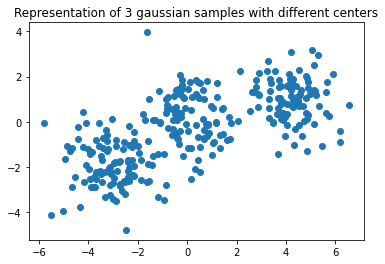

In [17]:
#Create random points

#number of points in each cluster
N = 100
#number of cluster
k = 3
#Fixe la seed
np.random.seed(1)
w_pts = np.ones((k*N,3))
w_pts[:N,:2] = np.random.randn(N,2)+[4,1]
w_pts[N:2*N,:2] = np.random.randn(N,2)+[-3,-2]
w_pts[2*N:,:2] = np.random.randn(N,2)+[0,0]
pts = w_pts[:,:2]
plt.scatter(w_pts[:,0],w_pts[:,1])
plt.title('Representation of 3 gaussian samples with different centers')
plt.show()

Below we present an interactive program that show each step of the k-cluster algorithm. Each color of the points of $X$ is associated with a cluster. In red we represent the centers that we used to compute the clusters and the red hollow circle is the mean of the clusters computed that will become the centers for the next clusters that we will compute. The lines represent the voronoi diagram of the centers. The lines are dotted if one of their side continue to the infinity. The principle is that the voronoi diagram represent the limit where each point will be at the same distance between 2 cluster's center. 

- The variables xlim_inf,xlim_sup,ylim_inf and ylim_sup represent the dimensions of the windows inside which we show the differents clusters.
- The step slider represent the step of the algorithm. The initialisation step is not show in the slider. 
- voro indicate if we want or not to compute the voronoi diagram of the centers.

Let use understand roughly how this works: 

At the first step we see that one cluster(the green one) has taken 2 sets degenerated by different normals. It will tend to go to the middle between the two normal's centers. Little by little at each steps the green cluster will have less and less points and tends to the left normal. For the 2 points inside the first cluster they will gradually increase their size. The most left-oriented center will tend to go the middle cluster and the other will go the right. 

In [19]:
M = pts[:k,:2].copy()
fct = k_means_solver(w_pts,M)
res = interact(fct.interactive_cluster,xlim_inf=widgets.FloatText(-4),
               xlim_sup=widgets.FloatText(4),ylim_inf=widgets.FloatText(-4),ylim_sup=widgets.FloatText(4), 
               step=widgets.IntSlider(min=1, max=len(fct.M_list)-1),debug=fixed(False))

interactive(children=(FloatText(value=-4.0, description='xlim_inf'), FloatText(value=4.0, description='xlim_su…

# The flaw of the k-means algorithm: 

Now that we better understand how this algorithm works, let's dig futher to see it's limit.

In 2009, Andrea Vattani wrote an article about the complexity of the k-means in the plane where he find a particular case where the algorithm has an exponential time. More precisely, given n and k such that $k=\Theta(n)$, the algorithm takes $2^{\Omega(n)}$. [1]

The algorithm is difficult to explain mathematically so I will explain how intuitively this algorithm is meant to work. Also the algorithm is difficult to illustre with the interactive program because the graph is too large and there seems to be some overflow when we want to compute the voronoi diagram of the cluster. Therefore, we will simply reuse the diagram used in the article and reexplain with our words how it works

The principle of this born is to control how the algorithm works to obtain an exponential time algorithm. Let $t$ be an integer. For this algorithm we will call $W_i$ for $i=0,...,t-1$ a watchman(which correspond to a set of point). Each watchman works in cycles of 3 step(morning, afternoon and night). 

- For $i>0$ the watchman $W_i$. The watchman is waiting to be awoken by $W_{i+1}$ and to begin his 'day' cycle
    - During the morning, $W_i$ check if $W_{i-1}$ is slepping. If yes, he wakes up $W_{i-1}$.
    - During the afternoon, $W_i$ check if $W_{i-1}$ is slepping. If yes, he wakes up $W_{i-1}$.
    - During the night, $W_i$ goes into sleep.

The figure 1 below illustrate this concept

- For $i=0$, the watchman has a two step cycle. If he is woken up, he stay awake one cycle and after it sleeps.


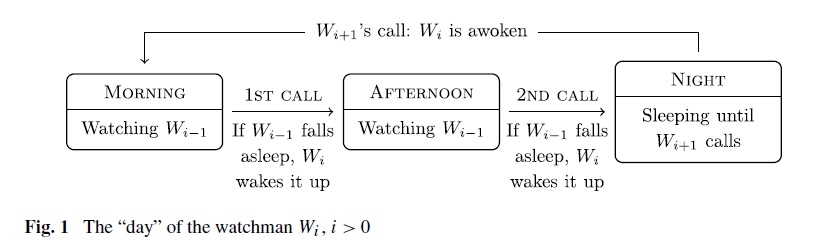